# Setting up depedencies

**July 13 2020**

This notebook details the results of the experiments that ran on grisou the 13 of July.
The experiment was too long to run on the allocated time, but I got a least on of each configuration.

None of the configuration with blocking broadcast managed to finish du to timeout.
(I setted the timeout to 45min).

The data folder is `experiments/g5k/data/grisou/`.


In [2]:
%load_ext rpy2.ipython

In [3]:
import sys 
import os
import math
import datetime
import glob
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("src"))
import analysis
reload(analysis)

/home/adfaure/Projects/ptask-eval/analysis


<module 'analysis' from '/home/adfaure/Projects/ptask-eval/analysis/src/analysis.py'>

In [4]:
%%R -w 18 -h 8 --units in
library(tidyverse)
library(viridis)

theme_set(theme_minimal(base_size = 18))

load_instance_grisou = function(path, noise) {
    instance = path
    data = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "Router (eno1)", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Router (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Tcpkali", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-11.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "MPI (only one host)", timestamp = timestamp - min(timestamp)) ) %>%
    mutate(noise = noise)
}

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packa

# Preparing the data

These functions loop thgough each configurations, extract the data and create the csv necessary for ploting the progress `mpi_progress.csv`.
This block creates a csv with all configurations.

In [5]:
base_folder = "../experiments/g5k/data/paravance/paravance_july_run1_13_july/"

subdiv1 = os.path.join(base_folder, "80K_256ranks_1bcast_1subdiv")
subdiv50 = os.path.join(base_folder, "80K_256ranks_1bcast_50subdiv")

data = []
for file in glob.glob(os.path.join(subdiv1, "*")):
    instances =  analysis.Instances(file)
    if(file.endswith("ibcast")):
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("1_subdivision", "IBcast", instances.name.replace("_ibcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)  
    else:
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("1_subdivision", "Bcast", instances.name.replace("_bcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)

for file in glob.glob(os.path.join(subdiv50, "*")):
    instances =  analysis.Instances(file)
    if(file.endswith("ibcast")):
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("50_subdivision", "IBcast", instances.name.replace("_ibcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)
    else:
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("50_subdivision", "Bcast", instances.name.replace("_bcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)

df = pd.DataFrame(data=data, columns=[ 'nb_sub', 'bcast', 'interference', 'runtime'])
df.to_csv(os.path.join(base_folder, "paravance_all_instance.csv"))

# Visualisation

First we print the bar plot of the different running times.
On can see, that none of the instances with 1 subdivisions, and blocking bcast suceed to finish before the timeout (of 45min).

In [1]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

ilevels = c("No interference",
            "15s interference / 45s idle", 
            "15s interference / 15s idle",  
            "30s interference / 30s idle",
            "45s interference / 15s idle", 
            "Constant interference")

theme_set(theme_minimal(base_size = 18))

data = read_csv("../experiments/g5k/data/paravance/paravance_july_run1_13_july/paravance_all_instance.csv") %>% 
    mutate(interference = str_replace(interference, "no_kali", "No interference")) %>%
    mutate(interference = str_replace(interference, "noper", "Constant interference")) %>%
    mutate(interference = str_replace(interference, "per15sidle45sinter", "45s interference / 15s idle")) %>%
    mutate(interference = str_replace(interference, "per45sidle15inter", "15s interference / 45s idle")) %>%
    mutate(interference = str_replace(interference, "per45sidle15sinter", "15s interference / 45s idle")) %>%
    mutate(interference = str_replace(interference, "per15s", "15s interference / 15s idle")) %>%
    mutate(interference = str_replace(interference, "periods30s", "30s interference / 30s idle")) %>%
    mutate(nb_sub = str_replace(nb_sub, "1_subdivision", "No subdivision"), 
           nb_sub = str_replace(nb_sub, "50_subdivision", "50 subdivisions")) %>%
    mutate(nb_sub = factor(nb_sub, levels = c("No subdivision", "50 subdivisions"))) %>% 
    mutate(bcast = str_replace(bcast, "IBcast", "Immediate broadcast"),
           bcast = str_replace(bcast, "Bcast", "Blocking broadcast"))

stats <- data %>% group_by(interference, nb_sub, bcast) %>% 
    summarise( sd_time = sd(runtime), mean_runtime = mean(runtime), n = n())

stats %>% ggplot(aes(y = mean_runtime, x = factor(interference, levels = ilevels), fill = bcast)) +
    geom_bar(stat = "identity", position = position_dodge())+  
    xlab("Interference pattern") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    geom_errorbar(aes(ymin = mean_runtime - sd_time, ymax = mean_runtime + sd_time), 
                  position = position_dodge(0.9), width = 0.5) +
    scale_fill_viridis_d(end = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw(base_size = ) +
    theme(legend.position = "bottom")

# We compute the increase percentage of interference compared to the run without interference
# - Mean runtime for each config
# - Find the config with the lowest (mean) runtime (should be the no interference)
# - Attach this runtime to the others means and compute the increase percentage ((mean_runtime - base) / base) * 100 
sums = data %>% group_by(bcast, nb_sub, interference) %>%
  summarize(mean = mean(runtime), sd = sd(runtime))

find_base = sums %>% group_by(bcast, nb_sub) %>% summarise(base = min(mean))

inc_percentages = full_join(sums, find_base, by= c("nb_sub", "bcast")) %>% 
  mutate(inc_percentage = (mean - base ) / base * 100, key = paste(bcast, nb_sub)) %>%
    write_csv("data/paravance_13_july.csv")

UsageError: Cell magic `%%R` not found.


# A tibble: 24 x 8
# Groups:   bcast, nb_sub [4]
   bcast    nb_sub   interference     mean    sd  base inc_percentage key       
   <chr>    <chr>    <chr>           <dbl> <dbl> <dbl>          <dbl> <chr>     
 1 Blockin… No subd… 15s interferen…  483. 0.540  449.           7.57 Blocking …
 2 Blockin… No subd… 15s interferen…  468. 0.366  449.           4.22 Blocking …
 3 Blockin… No subd… 30s interferen…  479. 0.385  449.           6.80 Blocking …
 4 Blockin… No subd… 45s interferen…  492. 0.283  449.           9.56 Blocking …
 5 Blockin… No subd… Constant inter…  512. 0.351  449.          14.2  Blocking …
 6 Blockin… No subd… No interference  449. 0.200  449.           0    Blocking …
 7 Blockin… 50 subd… 15s interferen…  374. 0.441  345.           8.37 Blocking …
 8 Blockin… 50 subd… 15s interferen…  358. 0.289  345.           3.86 Blocking …
 9 Blockin… 50 subd… 30s interferen…  373. 0.714  345.           8.25 Blocking …
10 Blockin… 50 subd… 45s interferen…  388. 0.392  345.      

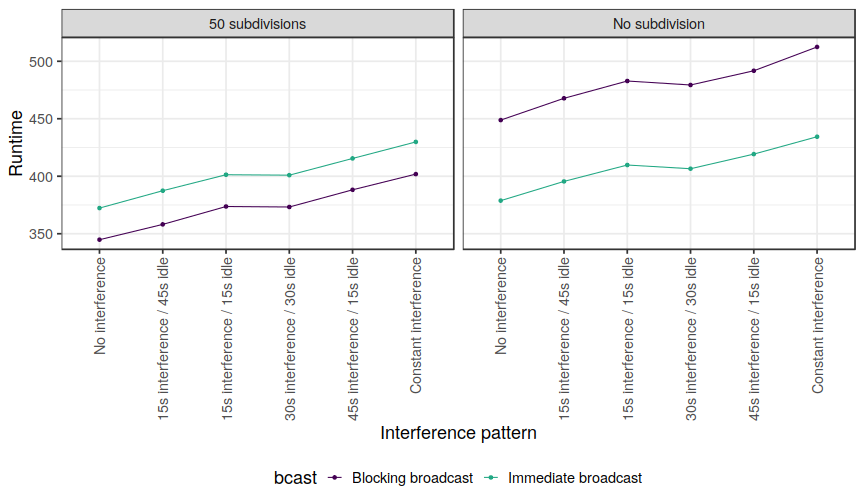

In [9]:
%%R -w 12 -h 7 --units in

print(inc_percentages)
inc_percentages %>% 
    ggplot(aes(y = mean, group = key, x = factor(interference, levels = ilevels), color = bcast)) +
    geom_point() +
    geom_line() +
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    

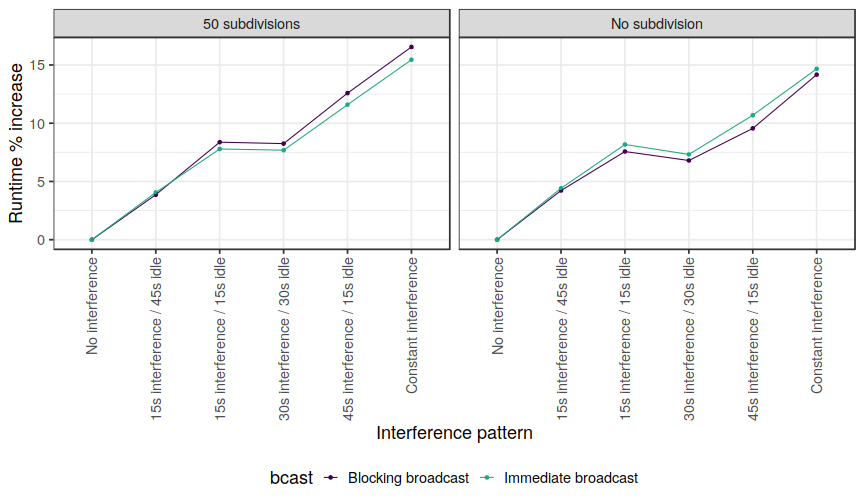

In [10]:
%%R -w 12 -h 7 --units in

inc_percentages %>% 
    ggplot(aes(y = inc_percentage, group = key, x = factor(interference, levels = ilevels), color = bcast)) +
    geom_point() +
    geom_line() +
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime % increase") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 18 x 8 in image

  warnings.warn(x, RRuntimeWarning)


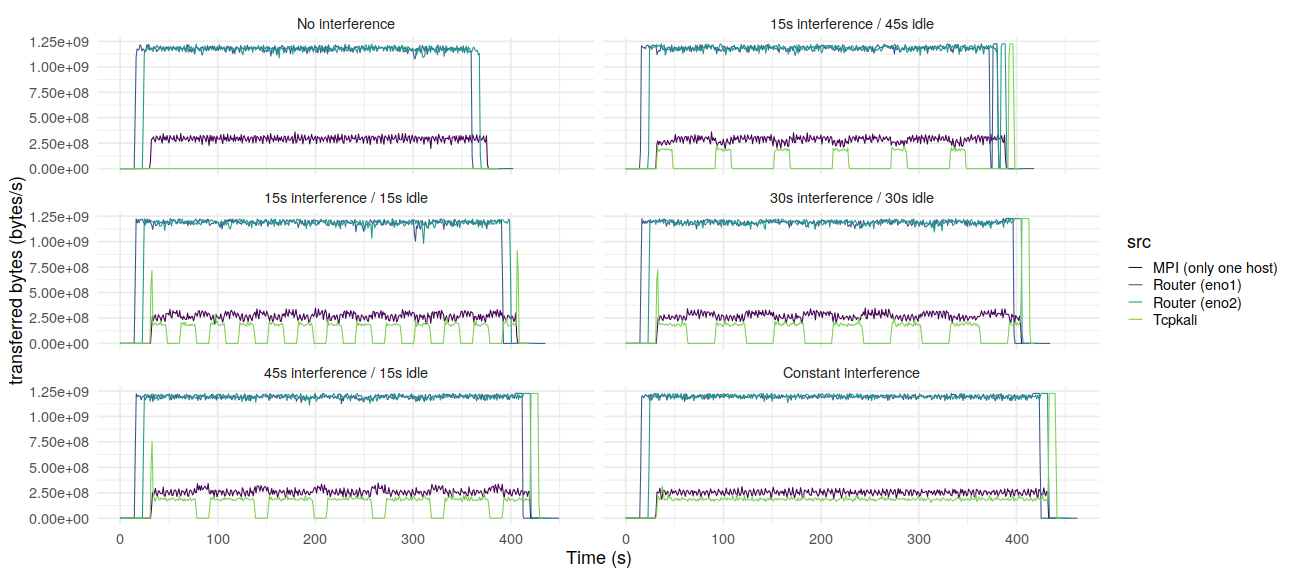

In [31]:
%%R -w 18 -h 8 --units in

ilevels = c("No interference",
            "15s interference / 45s idle", 
            "15s interference / 15s idle",  
            "30s interference / 30s idle",
            "45s interference / 15s idle", 
            "Constant interference")

path = "../experiments/g5k/data/paravance/paravance_july_run1_13_july/80K_256ranks_1bcast_50subdiv/"

full_inter   = load_instance_grisou(paste0(path,"256c_no_kali_bcast/57f03f2e/"), "No interference")
no_inter     = load_instance_grisou(paste0(path,"256c_noper_bcast/3584b3ce/"), "Constant interference") 
ten_inter    = load_instance_grisou(paste0(path,"256c_per15s_bcast/2d060ca8/"), "15s interference / 15s idle")
thirty_inter = load_instance_grisou(paste0(path,"256c_periods30s_bcast/2c6c49ab/"), "30s interference / 30s idle")
idle20if10   = load_instance_grisou(paste0(path,"256c_per45sidle15inter_bcast/10ecadfe/"),"15s interference / 45s idle")
idle10if20   = load_instance_grisou(paste0(path,"256c_per15sidle45sinter_bcast/4ac9317e/"), "45s interference / 15s idle")

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line(aes(color = src)) + facet_wrap(~noise, ncol = 2) +
        theme_minimal(base_size = 18) +
        scale_colour_viridis_d(end = 0.8) +
        ggsave("img/grisou_time.pdf")

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  X1 = col_double(),
  loop = col_double(),
  max_bcast_begin = col_double(),
  min_bcast_begin = col_double(),
  max_bcast_end = col_double(),
  min_bcast_end = col_double(),
  max_comp_begins = col_double(),
  min_comp_begins = col_double(),
  max_comp_end = col_double(),
  min_comp_end = col_double()
)

  warnings.warn(x, RRuntimeWarning)


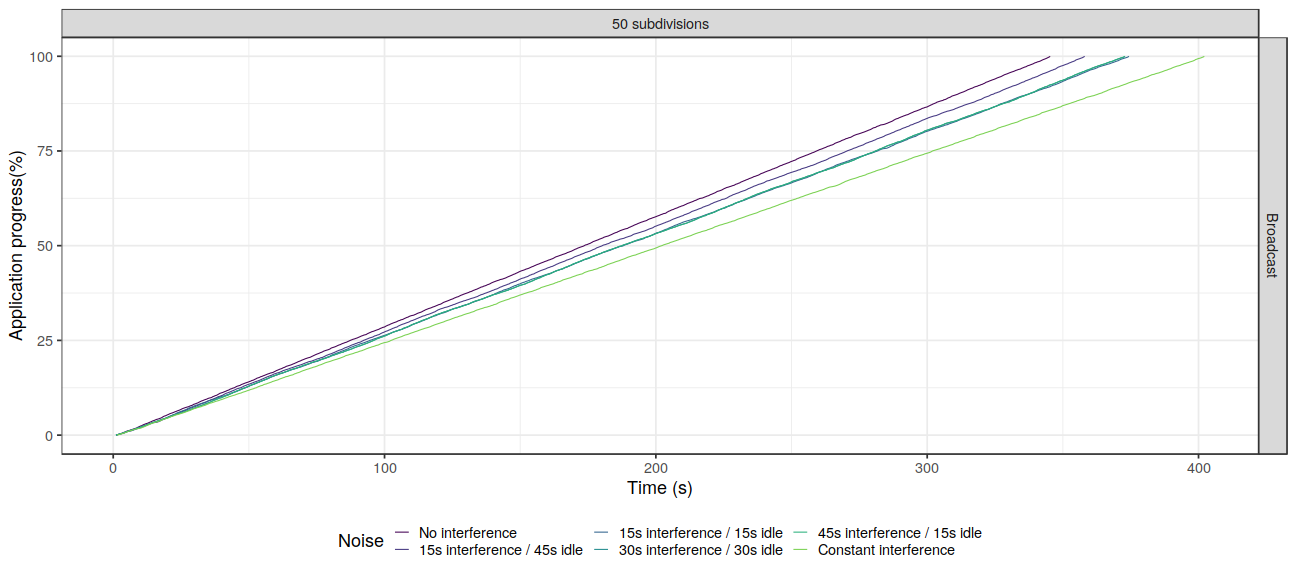

In [32]:
%%R -w 18 -h 8 --units in

path = "../experiments/g5k/data/paravance/paravance_july_run1_13_july/80K_256ranks_1bcast_50subdiv/"

s50ibcast =  read_csv(paste0(path,"256c_no_kali_bcast/57f03f2e/", "mpi_progress.csv")) %>%
                  mutate(noise = "No interference") %>%
    
        bind_rows(read_csv(paste0(path,"256c_noper_bcast/3584b3ce/",  "mpi_progress.csv")) %>%
                  mutate(noise = "Constant interference") ) %>%
        
        bind_rows( read_csv(paste0(path,"256c_per15s_bcast/2d060ca8/", "mpi_progress.csv")) %>%
                  mutate(noise = "15s interference / 15s idle") ) %>%
        
        bind_rows( read_csv(paste0(path,"256c_periods30s_bcast/2c6c49ab/", "mpi_progress.csv")) %>%
                  mutate(noise = "30s interference / 30s idle") ) %>%
            
        bind_rows( read_csv(paste0(path,"256c_periods30s_bcast/2c6c49ab/", "mpi_progress.csv")) %>%
                  mutate(noise = "45s interference / 15s idle") ) %>%
        
        bind_rows( read_csv(paste0(path,"256c_per45sidle15inter_bcast/10ecadfe/", "mpi_progress.csv")) %>%
                  mutate(noise = "15s interference / 45s idle") ) %>%
        mutate(src = "50 subdivisions", bcast = "Broadcast")  %>% mutate(progress = loop/max(loop)*100)
        
s50ibcast = s50ibcast %>% 
    mutate(nb_sub = factor(src, levels = c("No subdivision", "50 subdivisions"))) %>%
    rename("Noise" = "noise") %>%
    mutate(Noise = factor(Noise, levels = ilevels))
                                                                                          
s50ibcast %>% ggplot(aes(x = max_comp_end, y = progress)) +
    geom_line(aes(color = Noise)) + facet_grid(bcast~nb_sub) + 
    ylab("Application progress(%)") + xlab("Time (s)") +
    scale_colour_viridis_d(end = 0.8) + 
    theme_bw(base_size = 18) +
    theme(legend.position = "bottom") +
    ggsave("img/grisou_real_progress.pdf", height = 8)